In [ ]:
import nltk
import spanlp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
warnings.filterwarnings("ignore")
#nltk.download('book')

In [2]:
from spanlp.domain.strategies import Preprocessing, TextToLower, TextToUpper, RemoveUnicodeCharacters, RemovePunctuation, NumbersToVowelsInUpperCase, NumbersToConsonantsInUpperCase, NumbersToVowelsInLowerCase

In [3]:
resenas = pd.DataFrame(data = pd.read_csv("amazon_alexa.csv", sep="	"))
resenas.head(2)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1


In [4]:
resenas.isna().sum().sort_values()

rating              0
date                0
variation           0
feedback            0
verified_reviews    1
dtype: int64

In [5]:
def limpia(dataframe, variable):
    if isinstance(variable, float):
        variable = str(variable)
    variable.replace('ñ', 'n')
    estrategias = [TextToUpper(), NumbersToVowelsInUpperCase(), NumbersToConsonantsInUpperCase(), 
                   RemoveUnicodeCharacters(), RemovePunctuation(), NumbersToVowelsInLowerCase()]
    guardado = Preprocessing(data = variable, clean_strategies=estrategias).clean()
    return guardado


from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

resenas["verified_reviews_clear"] = resenas["verified_reviews"].apply(lambda x: limpia(resenas, x))
resenas["Ponderado"] = resenas["verified_reviews_clear"].apply(lambda x: sid.polarity_scores(x)["compound"])
resenas["variation"] = resenas["variation"].replace("Configuration: Fire TV Stick", "Config: Fire TV Stick") 

In [6]:
resenas["date"] = pd.to_datetime(resenas["date"])
resenas["date_year"] =  resenas["date"].dt.year
resenas["date_month"] = resenas["date"].dt.month
resenas["date_day"] = resenas["date"].dt.day

def resenas_category(dataframe, variable):
    if variable > 0.5:
        return "Positive"
    elif -0.5 <= variable <= 0.5:
        return "Neutro"
    elif variable < -0.5:
        return "Negative"

resenas["Category_resena"] = resenas["Ponderado"].apply(lambda x: resenas_category(resenas, x))

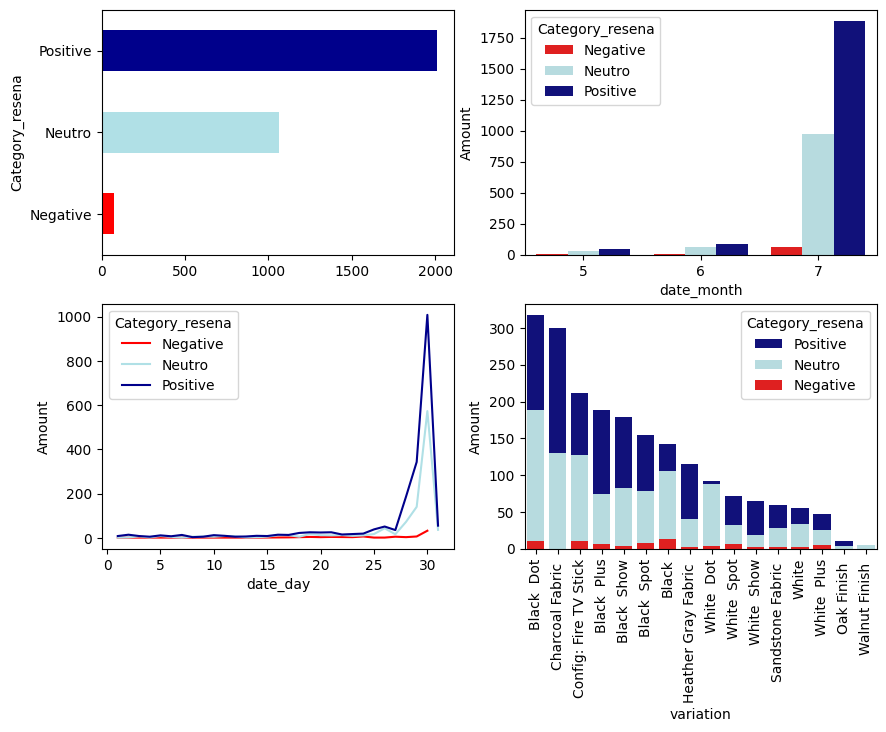

In [24]:
month_resenas = resenas.groupby(["date_month", "Category_resena"])["Category_resena"].size().reset_index(name = "Amount")
day_resenas = resenas.groupby(["date_day", "Category_resena"])["Category_resena"].size().reset_index(name = "Amount")
resenas_variation = resenas.groupby(["variation", "Category_resena"])["Category_resena"].size().reset_index(name = "Amount").sort_values(by = "Amount", ascending = False)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7))
colors = ["red", "powderblue", "darkblue"]
colors_2 = ["darkblue", "powderblue", "red"]


resenas.groupby("Category_resena").size().plot(kind = "barh", color = colors, ax = ax[0,0])
sns.barplot(data = month_resenas, x = "date_month", y = "Amount", hue = "Category_resena", palette = colors, ax = ax[0,1])
sns.lineplot(data = day_resenas, x = "date_day", y = "Amount", hue = "Category_resena", palette = colors, ax = ax[1,0])
sns.barplot(data = resenas_variation, x = "variation", y = "Amount", hue = "Category_resena", palette = colors_2, dodge=False, ax = ax[1,1])
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation = 90)

plt.show()